# GAN
* 생성을 하는 모델 - 새로운 이미지나 음성을 창작함
* 적대적으로 학습함 - 가짜 이미지 생성과 진위를 판별하는 판별자가 번갈아 학습하며 경쟁적 학습
  * 가짜로 만듦 -> 진위 판별: 가짜 -> 어떻게 알았지?하면서 더 비슷하게 만들기 -> ... 반복
* 비지도 학습

---

# GAN으로 새로운 패션 아이템 생성

In [ ]:
import os
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 하이퍼패러미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else 'cpu')
print(f"사용하고 있는 디바이스 : {DEVICE}")

사용하고 있는 디바이스 : cuda


In [ ]:
# 데이터셋 로딩
# Fashoin MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

### 생성자
> 실제 데이터와 비슷한 가짜 데이터를 만들어내는 신경망

- 정규분포로부터 뽑은 64차원의 무작위 텐서를 입력받아 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행
- Tanh 활성화 함수는 결과값을 -1과 1 사이로 압축하는 역할
- 결과값 = 이미지 = 784차원
- 무작위 텐서를 입력하는 이유? : 생성자가 실제 데이터의 '분포'를 배우는 것이기 때문
    - 수학적으로 그럴듯한 '가짜'는 '진짜'의 분포를 닮는다고 할 수 있음
    - 생성자는 정규분포 같은 단순한 분포에서부터 실제 데이터의 복잡한 분포를 배움



In [ ]:
# 생성자 (Generator)
# 생성자는 64차원의 랜덤한 텐서를 입력받아 -> 이에 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행
# 생성자의 결과값은 784차원 -> 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 784),
    nn.Tanh() # -1 ~ 1 -> 784에 있는 값들을 정리 
)

### 판별자
- 이미지의 크기인 784차원의 텐서를 입력 받음
- 입력된 데이터에 행렬곱과 활성화 함수를 실행
- 판별자는 입력된 784차원의 텐서가 생성자가 만든 가짜 이미지인지, 혹은 실제 데이터인지 구분하는 분류 모델

In [ ]:
# 판별자(Discriminator)
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
    
)

* 판별자에선 일반적으로 썼던 ReLU가 아니라 Leaky ReLU 활성화 함수를 사용
* Leaky ReLU 활성화 함수는 양의 기울기만 전달하는 ReLU와 다르게 약간의 음의 기울기도 다음 층에 전달하는 역할을 함
* 이렇게 하면 판별자에서 계산된 기울기가 0이 아니라 약한 음수 로 전환되며생성자에 더 강하게 전달
  * 음수는 * 0.2를 함
* GAN에서 생성자가 학습하려면 판별자로부터 기울기를 효과적으로 전달받아야 하므로 중요하다고 할 수 있음



## GAN 학습 구현

In [ ]:
# 모델 인스턴스 생성
D = D.to(DEVICE) # nn.Sequential을 통해 생성된 신경망 객체를 지정된 장치로 보내기
G = G.to(DEVICE) 

# 오차함수 & 최적화 함수
criterion = nn.BCELoss() # 이진 크로스 엔트로피(Binary Cross Entropy) 오차함수
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
# 시간상 - 강사님의 모델 사용
total_step = len(train_loader)
for epoch in range(EPOCHS):
    # i: 100개인데, 배치 사이즈가 10이면? [0, 1, 2, 3... 9]
    # (data, label) -> 이미지, 이미지의 분류
    # ---
    for i, (images, _) in enumerate(train_loader): # DataLoader는 BatchSize만큼 끊어서 데이터를 제공
        # BATCH_SIZE, 1, 28, 28 -> BATCH_SIZE, 784
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE) # 진짜 이미지

        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE) # 1로 채워진 텐서
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE) # 0로 채워진 텐서

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images) # 판별자가 진짜 이미지를 0~1으로 진짜/가짜 여부를 판단
        d_loss_real = criterion(outputs, real_labels) # BCELoss
        real_score = outputs # 판별자 vs 진짜 이미지

        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE) # 정규분포를 따르는 64개의 특성을 가진 가짜 이미지 텐서
        # 정규분포로부터 생성된 무작위 텐서를 (생성자 모델이) 입력받아서 실제 이미지와 차원(모양)이 같은 텐서를 생성
        fake_images = G(z)

        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        # 판별자가 맞추었는가?
        d_loss_fake = criterion(outputs, fake_labels) # 오차
        fake_score = outputs # 판별자 vs 가짜 이미지

        # 진짜와 가짜 이미지를 가지고 낸 오차
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step() # 판별자의 패러미터 개선

        # 생성자가 판별자를 속였는지에 대해 (생성자 성능) 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        # 생성자가 속였는가?
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step() # 생성자의 패러미터 개선
    # ---
    # 학습 진행도 체크 로그
    # 판별자가 진짜를 알아본 정확도 D(x)와 가짜를 진짜로 인식한 정확도 D(G(z))
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

In [ ]:
!wget https://github.com/bigdata-young/ai_26th/raw/main/etc/d.pt
!wget https://github.com/bigdata-young/ai_26th/raw/main/etc/g.pt

--2023-01-11 03:34:29--  https://github.com/bigdata-young/ai_26th/raw/main/etc/d.pt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bigdata-young/ai_26th/main/etc/d.pt [following]
--2023-01-11 03:34:29--  https://raw.githubusercontent.com/bigdata-young/ai_26th/main/etc/d.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1069863 (1.0M) [application/octet-stream]
Saving to: ‘d.pt’

d.pt                100%[===================>]   1.02M  --.-KB/s    in 0.006s  

2023-01-11 03:34:30 (180 MB/s) - ‘d.pt’ saved [1069863/1069863]

--2023-01-11 03:34:30--  https://github.com/bigdata-young/ai_26th/ra

In [ ]:
D.load_state_dict(torch.load('d.pt'))
G.load_state_dict(torch.load('g.pt'))

<All keys matched successfully>

## 결과물 시각화

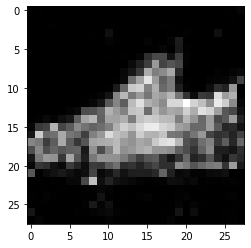

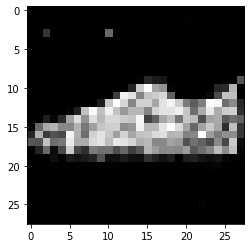

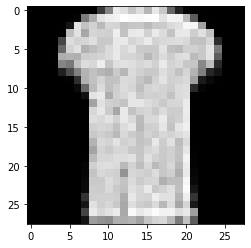

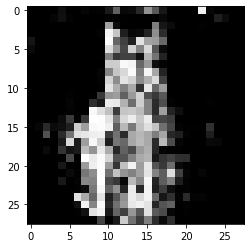

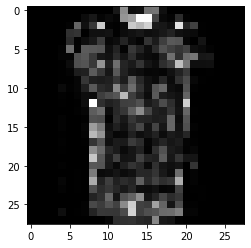

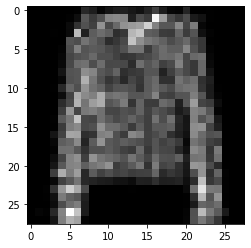

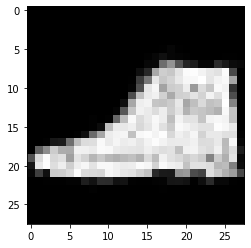

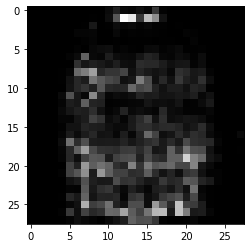

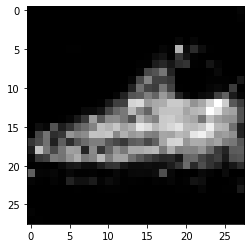

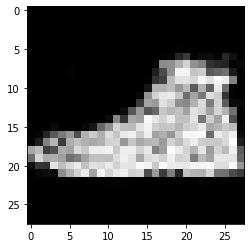

In [ ]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap ='gray')
    plt.show()

In [ ]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap ='gray')
    plt.show()